# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity

### In this version, we will be utilizing the full immune parameter space, sampling also which immune forces should be included in the calculation of the immune modifier (ie configurable params starting with "Immune_Modifier_Include*"

### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

from wand.image import Image as WImage
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

import pycuda
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

C:\conda\envs\history_matching\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 8
density_bin_cut = 50

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['08bb0d81-785f-ea11-a2c5-c4346bcb1550'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_ea92219ca3800142bf0a022604e3255c.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.0,20.0,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.0,5.0,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.0,20.0,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.0,5.0,Cumulative_Exposure_Immune_Coefficient_TM
Scale_Factor_Free_Interval_a,0.0,0.2,Scale_Factor_Free_Interval_a
Scale_Factor_Age_a,3.0,5.0,Scale_Factor_Age_a
Parasite_Density_Wave_Sigma,0.6,6.0,Parasite_Density_Wave_Sigma
Immune_Modifier_Include_Age,0.0,1.0,Immune_Modifier_Include_Age
Immune_Modifier_Include_Cumulative_Exposure,0.0,1.0,Immune_Modifier_Include_Cumulative_Exposure


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 08bb0d81-785f-ea11-a2c5-c4346bcb1550
08bb0d81-785f-ea11-a2c5-c4346bcb1550\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
44            0       2  15a64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
107           0      65  59a64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
170           0      55  3ca64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
233           0      96  7ca64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
296           0       6  19a64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   

     density_bin     value  
44            50  0.000000  
107           50  0.000444  
170           50  0.000000  
233           50  0.095180  
296           50  0.000000  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000000,13a64d87-785f-ea11-a2c5-c4346bcb1550,0.578231
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000001,14a64d87-785f-ea11-a2c5-c4346bcb1550,0.322163
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000002,15a64d87-785f-ea11-a2c5-c4346bcb1550,0.000000
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000003,16a64d87-785f-ea11-a2c5-c4346bcb1550,0.002249
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000004,17a64d87-785f-ea11-a2c5-c4346bcb1550,0.524483


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == np.inf]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


C:\conda\envs\history_matching\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\conda\envs\history_matching\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
186  PfPR by Parasitemia and Age Bin     W2     8.0      50.0    162.0   

     proportion  binomial error  
186    0.320988         0.03668  
Before logit, desired result is 0.321 [0.248, 0.394]: 


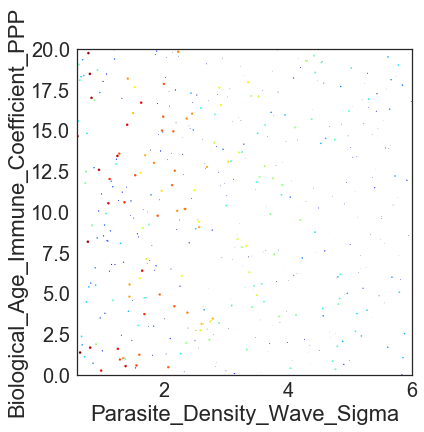

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_PPP'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 500 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 375 unique parameter configurations ( 375  simulations including replicates)
--> Testing  with 125  unique parameter configurations ( 125 simulations including replicates)


Found existing GLM basis with the following terms:


[Term([]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_TM')]),
 Term([EvalFactor('Cumulative_Exposure_Immune_Coefficient_PPP')]),
 Term([EvalFactor('Scale_Factor_Free_Interval_a')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_PPP * Biological_Age_Immune_Coefficient_TM')]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_PPP * Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_TM * Cumulative_Exposure_Immune_Coefficient_TM')]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_TM * Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Cumulative_Exposure_Immune_Coefficient_PPP * Cumulative_Exposure_Immune_Coefficient_TM')]),
 Term([EvalFactor('Cumulative_Exposure_Immune_Coefficient_TM * Scale_Factor_Free_Interval_a')])]

Would you like to use this basis? [Y]/n: n
Regularize:  0  of  15
Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


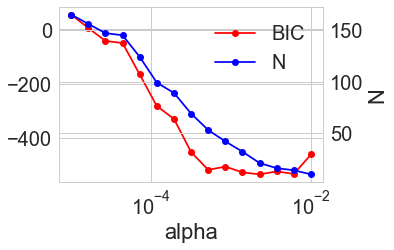

What would you like to use for the GLM regularization parameter, alpha_glm = 8e-3
User selected alpha = 0.008000
Non-Zero: 13 of 171
Regularization for GLM selected:
  * Intercept
 * Cumulative_Exposure_Immune_Coefficient_TM
 * Parasite_Density_Wave_Sigma
 * Immune_Modifier_Include_Age
 * Immune_Modifier_Include_Cumulative_Exposure
 * Immune_Modifier_Include_Recent_Exposure
 * Immune_Modifier_Include_Strain_Diversity
 * Immune_Modifier_Include_Malaria_Free_Interval
 * Immune_Modifier_Include_Age ** 2
 * Immune_Modifier_Include_Cumulative_Exposure ** 2
 * Cumulative_Exposure_Immune_Coefficient_PPP * Immune_Modifier_Include_Cumulative_Exposure
 * Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Cumulative_Exposure
 * Immune_Modifier_Include_Age * Immune_Modifier_Include_Cumulative_Exposure


In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\50_8_W2_Sugungum\GLM\GLM Predicted vs Actual.svg


In [15]:
basis_gpr = Basis.polynomial_basis(
#     params =  [
# 'Scale_Factor_Age_a', 
# 'Cumulative_Exposure_Immune_Coefficient_TM',
# 'Recent_Exposure_Immune_Coefficient_PPP',
# 'Recent_Exposure_Immune_Coefficient_TM',
# 'Parasite_Density_Wave_Sigma',
# 'Immune_Modifier_Include_Age',
# 'Immune_Modifier_Include_Strain_Diversity',
# 'Immune_Modifier_Include_Cumulative_Exposure'
#               ],
    params = param_info.index.values, 
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [0.09844299, 0.1256657, 0.0976875, 0.09889085, 0.1051974, 0.0950809, 0.10032171, 0.10599185, 0.10627393, 0.09950996, 0.09445544, 0.10285915, 0.10007409, 0.09847433, 0.08963389, 0.10205652, 0.09360044, 0.1024141, 0.09786228, 0.10247492, 0.09852253, 0.09632744, 0.09997534, 0.10767302, 0.10095249, 0.09941825, 0.10214923, 0.10221497, 0.09734157, 0.09093285, 0.10780673, 0.09881377, 0.10597152],
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Backing up gpr model to ..\iter0\Cuts\50_8_W2_Sugungum\GPR\model_2020_03_05_23_22_33.json
Fitting the GPR

	LL: 589.5719848027709 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25] 
	Deriv: [39.36511121 48.76731984 -6.17164643 -3.42668076 -2.02636011 -4.45308315
 -3.64447255 -4.6732945  -3.36790763  1.1418986   3.95658053  0.57460619
  0.70804253  1.30406703 -5.21237372 -5.45168224 -4.39522969 -5.09065602
 -4.11807334]

	LL: 3902.482132577153 
	Theta: [0.1        0.01       6.42164643 3.67668076 2.27636011 4.70308315
 3.89447255 4.9232945  3.61790763 0.01       0.01       0.01
 0.01       0.01       5.46237372 5.70168224 4.64522969 5.34065602
 4.36807334] 
	Deriv: [-1.49276056e+04 -2.57205305e+05  8.80006562e+00  6.89564293e+01
  1.87012968e+02  2.17981791e+01  1.37326495e+01  1.74998439e+00
  1.02268267e+02  6.99363909e-17 -1.81476336e-17  2.74049381e-18
 -2.71506438e-16 -1.51515910e-16  5.71594857e+00


	LL: 415.43687099238196 
	Theta: [1.45016129 0.23473973 3.10377646 1.77520335 1.03653029 2.27490813
 1.91157833 2.38798039 1.69913509 0.06956014 0.04587027 1.11602834
 1.14975139 0.11918936 2.64721276 2.74619894 2.22262017 2.57511133
 2.11841302] 
	Deriv: [ 2.41009842e+00  5.07979867e+01 -2.16574821e+00 -4.89366955e-02
  2.34853996e+01 -2.47104008e-01 -3.30385962e+00 -1.81669915e+00
  5.99297287e+00 -1.77899743e-01  4.62322874e-02  7.45809917e+00
  3.14702225e+00 -9.80373034e+00 -2.92820111e+00 -1.09487251e+00
  1.26922083e+00 -5.44326100e-01 -4.49762738e-01]

	LL: 547.9676720645532 
	Theta: [1.54406547 0.01117395 0.01       0.01638885 0.01305292 0.01348981
 0.01516844 0.0132066  0.01706362 0.06840062 0.02935852 1.19074018
 1.22945009 0.06639674 0.0124317  0.01208012 0.01467892 0.01249778
 0.01407167] 
	Deriv: [ 4.30414700e+01  4.30414853e+01 -3.30409928e-04 -6.17495830e-04
 -1.21870597e-04 -8.36082289e-04 -1.74054746e-04 -2.46283882e-03
 -2.38573217e-04 -9.14370423e-07  1.02122536e-0


	LL: 289.9396432923799 
	Theta: [2.39365106 0.01       7.59857421 2.59415053 0.20403007 4.42170207
 3.80810957 5.07783797 1.06879181 0.27660618 0.01       0.41670914
 1.17243314 0.01434178 6.01552832 5.99972136 3.84887728 5.48155943
 4.01145323] 
	Deriv: [ 2.17166843e+01  3.18553422e+02 -9.30766260e-01 -1.44610776e-01
  8.42763031e+00  1.24452258e+00 -2.77895922e+00 -1.61072933e+00
  8.42248022e+00  1.13977202e+01  7.01402565e-18 -1.39921742e+01
 -3.23982048e+00 -3.28329006e-11 -1.38046809e+00 -9.23649148e-01
 -2.54362099e+00 -1.62795079e+00 -1.43032113e+00]

	LL: 280.26291143709665 
	Theta: [2.0861458  0.01       8.98454576 2.89948634 0.19114003 5.11133242
 4.42659823 5.9358228  0.92704752 0.24230298 0.01       0.10763771
 0.72454428 0.01997225 7.07096874 7.03496558 4.42443518 6.41322153
 4.63999971] 
	Deriv: [ 1.92543069e+01  2.69267101e+02 -3.20767624e-01  5.11861557e-01
  3.72395722e+01  1.17062689e+00 -1.95125452e+00 -1.42009333e+00
  6.01967079e+00  1.57413948e+01  4.60507449e-1


	LL: 266.35912747335374 
	Theta: [8.77582556e-01 7.66148681e-02 1.62074775e+01 4.39904318e+00
 8.57360423e-02 8.51997600e+00 7.50819724e+00 1.02998736e+01
 3.83772353e-01 8.23064308e-02 2.13589911e-02 1.00000000e-02
 1.00000000e-02 1.17276193e-01 1.25049451e+01 1.23530736e+01
 7.24826593e+00 1.11727567e+01 7.75906962e+00] 
	Deriv: [ 7.57942961e+00  2.25349475e+02 -7.51844004e-02  5.64867415e-01
 -7.75371756e+00  2.25169838e-01 -1.60127833e-01 -2.80691100e-01
  3.60008478e+01  1.17958223e+00 -7.02131143e-07 -2.94330662e-17
 -3.83492923e-17 -1.74000696e+01 -1.41073652e-01 -1.69317193e-01
 -3.54375459e-01 -3.05852891e-01 -6.06151852e-01]

	LL: 623.1333428925584 
	Theta: [1.00000000e-01 8.62965547e-02 2.23280639e+01 4.67678732e+00
 1.00000000e-02 1.00864816e+01 8.67242654e+00 1.29978892e+01
 1.00000000e-02 1.00000000e-02 1.53461531e-02 1.00000000e-02
 1.00000000e-02 1.63321494e-01 1.64827218e+01 1.61875983e+01
 8.08407831e+00 1.43382346e+01 8.97048045e+00] 
	Deriv: [-3.41885185e+03 -9.019


	LL: 222.04961159203435 
	Theta: [5.40439625e-01 5.63422599e-02 6.82175170e+01 5.52607489e+00
 6.18522071e-02 2.00662159e+01 1.54259425e+01 3.18719032e+01
 1.96793439e-01 5.77344120e-02 1.78107118e-02 3.13795307e-01
 4.71167119e-01 5.27797271e-01 4.54565998e+01 4.40314012e+01
 1.22457331e+01 3.68993353e+01 1.61152655e+01] 
	Deriv: [-3.33344433e+01  5.69030162e+00  5.08835851e-03  2.89186293e-01
 -5.30281898e+01  2.61617476e-01  8.29717253e-02 -2.55467984e-02
  8.14808342e+01  2.06412832e-01 -1.89559869e-08 -1.30942633e+01
 -1.21897529e-01 -9.36451614e+00 -1.40412865e-03 -1.66732227e-03
 -1.80990209e-01 -3.67065399e-02 -1.89591273e-01]

	LL: 221.41926700637455 
	Theta: [6.47227642e-01 6.03191386e-02 8.95473520e+01 6.20065141e+00
 8.34295740e-02 2.50824671e+01 1.89845420e+01 4.09338095e+01
 2.09905622e-01 7.26425738e-02 2.58512300e-02 5.51215921e-01
 8.24483446e-01 7.04873362e-01 5.91052002e+01 5.71678584e+01
 1.46309912e+01 4.76370024e+01 1.98502420e+01] 
	Deriv: [-3.68363397e+01 -3.00


	LL: 215.19640620596152 
	Theta: [7.94613259e-01 4.61523829e-02 9.07089736e+01 6.54049179e+00
 7.37475629e-02 2.58710105e+01 1.97292892e+01 4.18139530e+01
 1.44603217e-01 6.48890870e-02 3.53976381e-02 3.50638011e-01
 5.42496342e-01 7.33546715e-01 6.00901934e+01 5.81431430e+01
 1.53644702e+01 4.85573468e+01 2.06112749e+01] 
	Deriv: [ 5.39054824e-01  9.59388428e+00  1.34398208e-02 -4.17485165e-02
  9.17584064e+00  2.82044030e-01  9.98105783e-02 -2.84559824e-02
  3.97934620e-01  5.74489727e-01 -5.39483254e-03 -5.99458914e-01
 -4.03082527e-01 -8.28196974e-01 -6.20427417e-03 -6.10442301e-03
 -1.79172972e-01 -3.28738117e-02 -1.60838716e-01]

	LL: 215.1695458505514 
	Theta: [7.81784257e-01 4.57561078e-02 9.11293536e+01 6.79014696e+00
 6.92379879e-02 2.62924749e+01 2.01540381e+01 4.22390134e+01
 1.40344947e-01 5.82429869e-02 3.81223268e-02 3.20838772e-01
 5.32407140e-01 7.70911830e-01 6.05135548e+01 5.85678188e+01
 1.57972487e+01 4.89830447e+01 2.10393909e+01] 
	Deriv: [ 6.56752917e-01  2.953


	LL: 215.02614080152992 
	Theta: [8.19984159e-01 4.02044849e-02 7.62091536e+01 7.00724384e+00
 7.03000334e-02 2.36749265e+01 1.86690182e+01 3.66079333e+01
 1.39188632e-01 4.04644090e-02 4.37358788e-02 2.91791473e-01
 6.03964064e-01 7.33468496e-01 5.14091023e+01 4.98552640e+01
 1.52507279e+01 4.20888808e+01 1.94556534e+01] 
	Deriv: [-9.85337458e-02 -1.66362689e+01  2.21180655e-02 -6.19294234e-02
 -7.68363389e-01  3.55852217e-01  1.18790855e-01 -3.94822461e-02
  7.97740414e-01  1.22777930e-02 -5.41331116e-02 -2.68445137e+00
  2.29454830e+00 -1.12226332e+00 -1.03840322e-02 -5.75161295e-03
 -1.93294257e-01 -4.47602147e-02 -1.89410906e-01]

	LL: 214.9428125737063 
	Theta: [8.34799112e-01 3.93316177e-02 6.48452541e+01 7.11792631e+00
 7.24430653e-02 2.15990629e+01 1.74495353e+01 3.22579774e+01
 1.41900688e-01 2.51795239e-02 4.71041771e-02 2.91974944e-01
 6.58165756e-01 7.04946469e-01 4.44364903e+01 4.31782845e+01
 1.47396604e+01 3.67850182e+01 1.81620408e+01] 
	Deriv: [-4.34728461e-01  1.792


	LL: 213.99269574632933 
	Theta: [8.87641489e-01 2.16088472e-02 1.21123660e+01 8.29669308e+00
 8.13957670e-02 1.28337239e+01 1.27625128e+01 1.27553805e+01
 1.52230900e-01 1.00000000e-02 7.25017339e-02 3.42319329e-01
 8.82584221e-01 7.15637433e-01 1.25083859e+01 1.26535072e+01
 1.34456005e+01 1.27674736e+01 1.31486135e+01] 
	Deriv: [-5.27261436e+00  1.86278650e+01  2.93406109e-01  6.94805681e-02
  2.62744249e+01  1.17665543e+00  1.62916653e-01 -2.78907033e-01
 -1.91379584e+01  1.08539672e-17 -2.02576252e+00  2.13681395e+00
  7.47701201e+00 -2.26965060e+00 -2.64751025e-01 -7.96941478e-02
 -3.43170210e-01 -4.13462685e-01 -3.17452955e-01]

	LL: 213.76681904882145 
	Theta: [9.08393889e-01 1.92785355e-02 1.33645229e+01 8.61795337e+00
 7.22622216e-02 1.35138344e+01 1.33972395e+01 1.35848173e+01
 1.51402489e-01 1.00000000e-02 7.77578685e-02 3.26331091e-01
 8.69930278e-01 7.70170916e-01 1.34959416e+01 1.36246662e+01
 1.40520604e+01 1.36564272e+01 1.37967575e+01] 
	Deriv: [-3.86410336e+00 -2.56


	LL: 209.1884680104007 
	Theta: [1.51778885e+00 1.00000000e-02 1.03491985e+01 1.29031322e+01
 9.15758451e-02 1.87411458e+01 1.94988815e+01 1.69406988e+01
 2.32618808e-01 1.00000000e-02 2.79281728e-01 2.27129897e-01
 7.25400789e-01 1.40076582e+00 1.44726722e+01 1.48850720e+01
 2.10039512e+01 1.61760032e+01 1.99705230e+01] 
	Deriv: [ 1.60006319e+00 -1.24986202e+02  2.74330484e-01 -2.43699159e-01
  3.36190063e+01  1.04215868e+00 -9.73342969e-03 -1.82570666e-01
  3.22497382e+00  8.50108522e-18 -1.82783920e+01 -6.09101643e-01
 -2.78288914e+00  1.92830324e+00 -2.41615114e-01 -1.82517056e-02
 -2.31754102e-01 -4.85627722e-01 -2.44582571e-01]

	LL: 209.0924426944863 
	Theta: [1.59218108e+00 1.17580720e-02 1.11028240e+01 1.41811901e+01
 9.02283815e-02 2.06185036e+01 2.15074817e+01 1.85775995e+01
 2.42021685e-01 1.00000000e-02 2.99911375e-01 1.57601741e-01
 6.97989909e-01 1.59800960e+00 1.57795428e+01 1.62346451e+01
 2.31561566e+01 1.77005226e+01 2.20030081e+01] 
	Deriv: [ 8.93027260e-01 -4.9003


	LL: 207.0444297501957 
	Theta: [1.44309494e+00 1.40674332e-02 1.04129939e+01 1.35413310e+01
 8.61942592e-02 1.95753945e+01 2.04380859e+01 1.76218715e+01
 2.20914938e-01 1.00000000e-02 4.53656525e-01 2.57182035e-01
 7.55389006e-01 1.48212464e+00 1.49265075e+01 1.53640954e+01
 2.20378500e+01 1.67822058e+01 2.09253709e+01] 
	Deriv: [ 6.09958008e-01  5.38980367e+00  3.05878099e-01 -1.64614191e-01
  4.23931722e+00  9.04801643e-01 -3.22198171e-02 -1.84999975e-01
 -1.95074434e+00  5.14929295e-18 -7.50709851e-01  3.45078957e-01
  2.58421296e+00  3.45103236e+00 -2.88674954e-01 -5.16778512e-03
 -2.18888536e-01 -4.52177662e-01 -2.20233080e-01]

	LL: 207.03216431306387 
	Theta: [1.45600593e+00 1.40857401e-02 1.07141745e+01 1.35702318e+01
 8.62011251e-02 1.96744608e+01 2.05196898e+01 1.77720412e+01
 2.22335719e-01 1.00000000e-02 4.56588069e-01 2.58243389e-01
 7.50373937e-01 1.48727845e+00 1.51332000e+01 1.55644896e+01
 2.21062352e+01 1.69532051e+01 2.10101652e+01] 
	Deriv: [ 7.38117172e-01  2.341


	LL: 206.283835277117 
	Theta: [1.34331781e+00 1.13760676e-02 9.22054571e+00 1.40827266e+01
 8.33036921e-02 1.99761777e+01 2.10866417e+01 1.77294414e+01
 1.87033517e-01 1.00000000e-02 5.08965798e-01 1.59532052e-01
 6.73815791e-01 1.22106464e+00 1.45755639e+01 1.50416214e+01
 2.28445770e+01 1.67485962e+01 2.15841182e+01] 
	Deriv: [ 1.72485948e+00 -8.53486467e+00  3.72328908e-01 -7.31300284e-02
 -1.83789658e-01  8.44659854e-01 -9.79432338e-03 -2.18293825e-01
 -2.89644373e+00  5.02842721e-19  2.01471340e+00 -5.00405627e+00
  5.51491025e-01  4.49344619e-01 -3.51448430e-01 -3.84957007e-03
 -1.68046420e-01 -4.55394570e-01 -2.20748954e-01]

	LL: 206.27455258619304 
	Theta: [1.34473537e+00 1.15775286e-02 9.36870836e+00 1.40063432e+01
 8.32574050e-02 1.99067680e+01 2.09912297e+01 1.77072744e+01
 1.89047160e-01 1.00000000e-02 5.02645594e-01 1.66406398e-01
 6.78062669e-01 1.22579799e+00 1.46158178e+01 1.50756837e+01
 2.27284252e+01 1.67476201e+01 2.14879494e+01] 
	Deriv: [ 1.67035801e+00 -8.8811


	LL: 205.55128897993245 
	Theta: [1.17465254e+00 1.51051747e-02 8.32807065e+00 1.56047948e+01
 7.69849864e-02 2.17321420e+01 2.32210825e+01 1.89736426e+01
 1.71271938e-01 1.00000000e-02 4.93501979e-01 2.14132252e-01
 5.71066491e-01 1.19600445e+00 1.50540901e+01 1.55820447e+01
 2.52641531e+01 1.77470672e+01 2.37480139e+01] 
	Deriv: [-9.58095488e-01 -4.15581882e+00  3.38734790e-01  3.79552209e-03
 -2.74789383e+00  7.24902413e-01  1.76473309e-02 -2.05362137e-01
  1.80510299e+00  2.09990550e-20  8.79746137e-01 -8.00729332e-01
 -3.22307630e+00  7.56643672e-01 -3.02441827e-01 -1.38312057e-02
 -1.07898711e-01 -3.80773319e-01 -1.66111042e-01]

	LL: 205.5456454786699 
	Theta: [1.18067953e+00 1.51731221e-02 8.33594572e+00 1.56493961e+01
 7.72593575e-02 2.17961705e+01 2.32892770e+01 1.90233770e+01
 1.71184210e-01 1.00000000e-02 4.90708444e-01 2.15567996e-01
 5.72301283e-01 1.21211277e+00 1.50876114e+01 1.56181069e+01
 2.53383989e+01 1.77906460e+01 2.38167552e+01] 
	Deriv: [-7.83472824e-01  1.820


	LL: 448.7458312421701 
	Theta: [1.08798403e+00 9.80552158e-02 1.71351816e-01 4.93531782e+01
 1.80125930e-02 6.31712679e+01 7.24735267e+01 5.16594375e+01
 1.00000000e-02 1.00000000e-02 1.12911106e-01 1.00000000e-02
 1.00000000e-02 1.00000000e-02 3.33206228e+01 3.48296244e+01
 8.02633178e+01 4.59658958e+01 7.38684881e+01] 
	Deriv: [ 5.62300726e+01  1.48355694e+02 -1.89450070e+02 -3.19103934e-03
 -9.11783524e+02 -9.08274191e-04 -1.65233508e-03 -3.01997369e-03
 -2.64753275e+03  6.36677439e-18  6.57030055e+00 -1.08289308e-17
 -1.70958460e-17 -1.52804080e-17 -8.87290389e-03 -1.02682005e-02
 -1.36961964e-03 -5.02590499e-03 -1.26443065e-03]

	LL: 217.76889904972825 
	Theta: [1.26585723e+00 4.20253102e-02 6.61349575e+00 2.95983458e+01
 6.17836240e-02 3.93006288e+01 4.38581127e+01 3.31810092e+01
 1.37739760e-01 1.00000000e-02 3.95069490e-01 1.85850421e-01
 4.27684529e-01 9.12634694e-01 2.36438905e+01 2.45541875e+01
 4.81862201e+01 3.02189684e+01 4.47571268e+01] 
	Deriv: [ 2.84703019e+01  4.658


	LL: 204.0520160787531 
	Theta: [1.70981399e+00 1.72413655e-02 1.03717784e+01 2.94092393e+01
 8.61644293e-02 3.99854767e+01 4.40828535e+01 3.44604593e+01
 1.96147583e-01 1.00000000e-02 5.76703113e-01 1.47720708e-01
 6.57596157e-01 1.45525500e+00 2.57922039e+01 2.66575915e+01
 4.81621377e+01 3.17682501e+01 4.50012439e+01] 
	Deriv: [-1.03936461e+00 -7.33977347e+00  2.15152805e-01  3.40563415e-02
 -2.50410083e-01  3.79160700e-01  2.04974298e-02 -9.11662597e-02
  2.35034821e-01 -2.63431605e-18  2.42472462e-01 -1.38689738e+00
 -1.24405026e+00  6.37278910e-01 -1.49599906e-01  1.30755459e-02
 -3.78799663e-02 -1.88625705e-01 -7.52548820e-02]

	LL: 204.0533822190746 
	Theta: [1.68162772e+00 1.75860775e-02 1.00981515e+01 2.92557866e+01
 8.49514827e-02 3.97270959e+01 4.38169394e+01 3.41878788e+01
 1.92998278e-01 1.00000000e-02 5.79746847e-01 1.51034479e-01
 6.57341723e-01 1.44015062e+00 2.55172278e+01 2.63840742e+01
 4.78884664e+01 3.14927215e+01 4.47292636e+01] 
	Deriv: [-4.94293031e-01  1.0620


	LL: 204.00373630663393 
	Theta: [1.73976726e+00 1.78911371e-02 1.05285655e+01 3.00985139e+01
 8.71053474e-02 4.08929518e+01 4.51290934e+01 3.52594103e+01
 1.99435973e-01 1.00000000e-02 5.79433293e-01 1.50410737e-01
 6.95091507e-01 1.44030765e+00 2.63706557e+01 2.72457499e+01
 4.93080916e+01 3.25028333e+01 4.60704426e+01] 
	Deriv: [-1.13941108e+00  1.00151662e+01  2.03846071e-01  3.23623164e-02
  4.16418865e+00  3.65760578e-01  2.11124797e-02 -8.56819974e-02
 -8.38172911e-01 -2.49507008e-18  3.26707769e-01 -1.50574798e+00
  3.99230219e-01  5.00798353e-01 -1.42887896e-01  1.53803995e-02
 -3.83659641e-02 -1.81791634e-01 -7.37482615e-02]

	LL: 204.00488021152646 
	Theta: [1.76753075e+00 1.71776236e-02 1.05748923e+01 3.03478717e+01
 8.81672392e-02 4.12256755e+01 4.55085515e+01 3.55446430e+01
 2.00873770e-01 1.00000000e-02 5.86957937e-01 1.44323527e-01
 7.03722294e-01 1.44678650e+00 2.65719591e+01 2.74526162e+01
 4.97243161e+01 3.27621927e+01 4.64577395e+01] 
	Deriv: [-1.75397580e+00 -1.78


	LL: 203.92569181188895 
	Theta: [1.89490982e+00 1.81389122e-02 1.05836449e+01 3.13633535e+01
 8.93524919e-02 4.25299527e+01 4.70303223e+01 3.66402673e+01
 2.12933646e-01 1.00000000e-02 6.05604164e-01 1.74616878e-01
 7.14987229e-01 1.45956188e+00 2.72895745e+01 2.81908378e+01
 5.14081417e+01 3.37425199e+01 4.80134499e+01] 
	Deriv: [ 6.69204278e-01  3.98758255e+01  1.19002335e-01  1.62250356e-02
 -1.04647027e+01  3.52079208e-01  1.65627730e-02 -7.95448000e-02
 -2.64954344e+00 -2.53255913e-18  3.83140820e-02 -1.94840197e-01
 -3.89463655e-01 -1.77066790e-01 -1.35032020e-01  1.55286525e-02
 -4.02670097e-02 -1.76512008e-01 -7.16246033e-02]

	LL: 203.9133306472173 
	Theta: [1.88400180e+00 1.76192195e-02 1.03929461e+01 3.13417208e+01
 8.94904521e-02 4.24627463e+01 4.69729376e+01 3.65408926e+01
 2.11994955e-01 1.00000000e-02 6.14644055e-01 1.73170977e-01
 7.18622583e-01 1.45351370e+00 2.71556405e+01 2.80611760e+01
 5.13586627e+01 3.36302306e+01 4.79539538e+01] 
	Deriv: [ 4.70699722e-02  1.449


	LL: 203.8966259419571 
	Theta: [1.93990531e+00 1.73996429e-02 1.07795721e+01 3.19654344e+01
 9.05445324e-02 4.33284514e+01 4.79549543e+01 3.73675703e+01
 2.16883123e-01 1.00000000e-02 6.02116146e-01 1.74009285e-01
 7.39643172e-01 1.46607640e+00 2.78389140e+01 2.87427116e+01
 5.24183224e+01 3.44210628e+01 4.89615417e+01] 
	Deriv: [-1.46669846e-01 -4.37541495e-02  1.29579335e-01  1.58196916e-02
 -3.03557341e+00  3.60041611e-01  1.79242370e-02 -7.56606908e-02
  1.52974558e-01 -2.59260000e-18 -8.08729146e-03  2.65879595e-01
  4.20609327e-01 -1.26809170e-01 -1.30135883e-01  2.25359697e-02
 -4.06064852e-02 -1.74739370e-01 -7.08633514e-02]

	LL: 203.92943175679812 
	Theta: [1.99052471e+00 1.82687221e-02 1.12527329e+01 3.22503846e+01
 9.09031797e-02 4.37873632e+01 4.84436528e+01 3.78645729e+01
 2.20710566e-01 1.00000000e-02 5.87270450e-01 1.77081340e-01
 7.42321270e-01 1.49228324e+00 2.83360988e+01 2.92319538e+01
 5.29252978e+01 3.49250460e+01 4.94645867e+01] 
	Deriv: [ 8.91827115e-01  4.549


	LL: 203.85428136636 
	Theta: [2.02291916e+00 1.73101487e-02 1.08955694e+01 3.27378109e+01
 9.14287033e-02 4.42372440e+01 4.91283649e+01 3.82864445e+01
 2.26304121e-01 1.00000000e-02 6.02913509e-01 1.55540464e-01
 7.63499383e-01 1.51985191e+00 2.85209113e+01 2.93880851e+01
 5.37249041e+01 3.52958422e+01 5.01900813e+01] 
	Deriv: [-2.75025877e-01  5.71580221e+00  1.02184556e-01  1.04983176e-02
 -9.11093363e+00  3.55257153e-01  1.61646902e-02 -6.99017267e-02
  2.91137008e+00 -2.64959625e-18  1.43938875e-01 -1.09606696e+00
  9.40681730e-01  2.19372735e-01 -1.24855537e-01  2.70719106e-02
 -4.13974622e-02 -1.71966662e-01 -7.09589172e-02]

	LL: 203.82742489991404 
	Theta: [1.98027705e+00 1.66531795e-02 1.04020468e+01 3.27411407e+01
 9.13696127e-02 4.40196677e+01 4.90687394e+01 3.81377977e+01
 2.21363313e-01 1.00000000e-02 5.96572882e-01 1.30714237e-01
 7.62407178e-01 1.50734585e+00 2.82909285e+01 2.91154894e+01
 5.37119405e+01 3.51465429e+01 5.01569015e+01] 
	Deriv: [-1.05978151e+00 -1.68275


	LL: 203.62831596336372 
	Theta: [2.02625747e+00 1.56542406e-02 9.56534418e+00 3.38252770e+01
 9.19922393e-02 4.45913691e+01 5.05918156e+01 3.92228175e+01
 2.16927758e-01 1.00000000e-02 5.48475554e-01 5.89684164e-02
 7.35880551e-01 1.59029067e+00 2.89450576e+01 2.95113699e+01
 5.55541793e+01 3.62541980e+01 5.18785142e+01] 
	Deriv: [-1.87132168e-02 -1.99064553e+00 -3.81541391e-02  1.99871836e-02
  3.43797375e+00  3.69640332e-01  1.55797915e-02 -7.36420657e-02
  2.21092639e+00 -3.37461305e-18 -2.32753689e+00 -7.67072104e-02
  1.52398603e-01  7.95562166e-01 -1.31991347e-01  1.73636603e-02
 -3.64744937e-02 -1.68321920e-01 -6.81624285e-02]

	LL: 203.60551387130567 
	Theta: [2.02685239e+00 1.58127184e-02 9.46509718e+00 3.42194050e+01
 9.17915159e-02 4.49746670e+01 5.11671426e+01 3.96415411e+01
 2.18193974e-01 1.00000000e-02 5.43475595e-01 5.00168213e-02
 7.42129532e-01 1.57750716e+00 2.92193177e+01 2.97509252e+01
 5.62117463e+01 3.66529431e+01 5.24901607e+01] 
	Deriv: [-3.06644993e-02 -1.92


	LL: 203.0994561533234 
	Theta: [2.84930566e+00 1.49338743e-02 1.15761492e+01 4.56774093e+01
 1.02710790e-01 5.79230852e+01 6.85996893e+01 5.35999079e+01
 2.54330933e-01 1.00000000e-02 6.56151240e-01 5.00189925e-02
 8.34647508e-01 1.73892188e+00 3.99014956e+01 3.96219743e+01
 7.56587025e+01 5.01868988e+01 7.08622980e+01] 
	Deriv: [ 9.16101571e-01 -1.12102186e+00 -1.11998060e-01  9.75022654e-03
  3.08069125e+00  2.95638231e-01  8.88477321e-03 -4.50143912e-02
 -1.73319741e+00 -4.78273060e-18 -3.81491244e-01 -2.82195156e-03
  1.76587663e-01 -1.60207621e-01 -9.01537079e-02  2.23619728e-02
 -2.97344083e-02 -1.21488986e-01 -5.00496021e-02]

	LL: 203.09626635992424 
	Theta: [2.94371781e+00 1.45559922e-02 1.19246495e+01 4.62166561e+01
 1.02395605e-01 5.85145386e+01 6.94590673e+01 5.43909561e+01
 2.52685998e-01 1.00000000e-02 6.66404651e-01 6.76193743e-02
 8.27458869e-01 1.82318736e+00 4.06106265e+01 4.02510585e+01
 7.66120332e+01 5.10013148e+01 7.17906071e+01] 
	Deriv: [ 1.45408890e+00  8.277


	LL: 202.75832386871394 
	Theta: [2.62286815e+00 1.72665325e-02 1.04085586e+01 4.64932077e+01
 9.85594241e-02 5.75138160e+01 6.96722300e+01 5.44581730e+01
 2.47954353e-01 1.00000000e-02 6.86489277e-01 1.80220427e-01
 8.00878883e-01 1.77180843e+00 4.04905118e+01 3.97010065e+01
 7.71061266e+01 5.12531046e+01 7.22606313e+01] 
	Deriv: [ 4.99377138e-01  1.15500586e+01 -1.78351294e-01  1.43002728e-02
 -1.92713104e+00  2.88284166e-01  9.78753823e-03 -4.45107111e-02
  9.77650689e-01 -5.30537742e-18  1.26007147e-01  2.17578565e+00
  5.68784674e-02  2.33458721e-01 -8.17503969e-02  2.14000783e-02
 -2.52331921e-02 -1.08854277e-01 -4.27084176e-02]

	LL: 202.7455322174767 
	Theta: [2.64769616e+00 1.71293173e-02 1.06502008e+01 4.66249325e+01
 9.95105751e-02 5.77876392e+01 6.98996173e+01 5.46746112e+01
 2.51205822e-01 1.00000000e-02 6.65763330e-01 1.70242089e-01
 8.15220613e-01 1.78345620e+00 4.06983549e+01 3.99313265e+01
 7.73318998e+01 5.14558641e+01 7.24797918e+01] 
	Deriv: [ 1.50508338e-01  4.826


	LL: 202.64685192223726 
	Theta: [2.40291607e+00 1.71051851e-02 9.57925130e+00 4.52873181e+01
 9.61443189e-02 5.55912309e+01 6.77570998e+01 5.29043657e+01
 2.28216811e-01 1.00000000e-02 6.43365277e-01 1.59426959e-01
 7.88085370e-01 1.76315012e+00 3.92521854e+01 3.83654283e+01
 7.50769123e+01 4.98358705e+01 7.03511276e+01] 
	Deriv: [-4.52091252e-02  1.02280580e+01 -2.11724626e-01  2.62613472e-02
  9.85665012e+00  2.98209753e-01  1.20670487e-02 -4.95760187e-02
 -1.33807913e+00 -5.50995717e-18 -4.30133143e-01  1.12560250e+00
  1.10909328e+00  8.12502750e-01 -8.92912910e-02  1.68898249e-02
 -2.30017174e-02 -1.09913856e-01 -4.28453065e-02]

	LL: 202.630627550353 
	Theta: [2.41933166e+00 1.73345450e-02 9.54544686e+00 4.63344032e+01
 9.60517892e-02 5.65747421e+01 6.93191526e+01 5.41431208e+01
 2.27424523e-01 1.00000000e-02 6.50804636e-01 1.60097029e-01
 7.95318178e-01 1.76544505e+00 4.01781794e+01 3.91540573e+01
 7.68576594e+01 5.10669158e+01 7.20348196e+01] 
	Deriv: [ 1.47088932e-02  1.6378


	LL: 202.3182394277876 
	Theta: [2.75148556e+00 1.73566227e-02 1.14188928e+01 5.32829022e+01
 9.83149425e-02 6.33359039e+01 7.99771644e+01 6.32941240e+01
 2.40969530e-01 1.00000000e-02 6.83213413e-01 1.39148120e-01
 7.70511019e-01 2.08928620e+00 4.77634398e+01 4.56751431e+01
 8.88855077e+01 6.03973467e+01 8.35834335e+01] 
	Deriv: [-8.10267215e-01  1.31372382e+00 -9.64154650e-02  2.68738549e-02
 -1.36622944e+00  2.65474815e-01  9.65476886e-03 -3.85142542e-02
  2.94022111e+00 -5.18982703e-18  7.54812666e-01 -1.20241854e-01
  1.58614657e-01  1.68770214e+00 -7.19429444e-02  1.93207662e-02
 -1.84233958e-02 -9.10508151e-02 -3.44803596e-02]

	LL: 202.30969621836428 
	Theta: [2.72666946e+00 1.73090903e-02 1.12921723e+01 5.31288374e+01
 9.79975872e-02 6.31139802e+01 7.97294048e+01 6.30764280e+01
 2.39044021e-01 1.00000000e-02 6.78930327e-01 1.31521960e-01
 7.67681996e-01 2.07751563e+00 4.75745411e+01 4.54874053e+01
 8.86200829e+01 6.01862794e+01 8.33287364e+01] 
	Deriv: [-8.08427393e-01  2.669


	LL: 202.18302503947316 
	Theta: [2.80103047e+00 1.67169769e-02 1.15109922e+01 5.62046271e+01
 9.91883945e-02 6.60211326e+01 8.43572863e+01 6.68493298e+01
 2.36159423e-01 1.00000000e-02 6.62150535e-01 9.38740026e-02
 7.37955528e-01 2.01978506e+00 5.05048777e+01 4.79886436e+01
 9.38785117e+01 6.39722906e+01 8.83263299e+01] 
	Deriv: [-4.00937359e-01 -6.14197872e+00 -1.00429396e-01  3.01679287e-02
 -4.25694286e+00  2.55152528e-01  1.09096542e-02 -3.82013705e-02
  2.68322936e+00 -5.23810280e-18 -4.86064490e-01  6.92754467e-03
 -1.72824720e+00  1.02704303e+00 -6.67155051e-02  1.59158082e-02
 -1.48337456e-02 -8.47437303e-02 -3.18285986e-02]

	LL: 202.19354956788786 
	Theta: [2.79261495e+00 1.66865001e-02 1.15512078e+01 5.49225837e+01
 9.86560073e-02 6.47925234e+01 8.24458738e+01 6.53418386e+01
 2.32973464e-01 1.00000000e-02 6.59385476e-01 1.25752633e-01
 7.23403258e-01 2.01056609e+00 4.93852469e+01 4.70258283e+01
 9.17035101e+01 6.24816966e+01 8.62726883e+01] 
	Deriv: [ 3.56851662e-01  1.38


	LL: 202.03161982075017 
	Theta: [3.04128885e+00 1.57431083e-02 1.31186783e+01 5.58217270e+01
 1.01933319e-01 6.62682053e+01 8.40025264e+01 6.69325492e+01
 2.38481159e-01 1.00000000e-02 6.82693744e-01 1.00000000e-02
 7.99108165e-01 2.02815009e+00 5.09814396e+01 4.86018901e+01
 9.33154175e+01 6.40907374e+01 8.78742741e+01] 
	Deriv: [ 3.01775285e-01  1.40843269e+01 -2.78046439e-02  2.72610762e-02
 -1.09858678e+01  2.56941545e-01  9.20227582e-03 -3.84638447e-02
 -6.69668252e+00 -5.09299689e-18  1.24597655e-01  4.87647916e-20
 -4.62861271e-02  7.47660374e-01 -7.24931073e-02  1.54078063e-02
 -1.89474242e-02 -9.06355101e-02 -3.52702006e-02]

	LL: 202.01263744626033 
	Theta: [3.05737169e+00 1.58744520e-02 1.33312794e+01 5.60649408e+01
 1.02336874e-01 6.65450449e+01 8.43940409e+01 6.73063377e+01
 2.41156480e-01 1.00000000e-02 6.69941030e-01 1.00000000e-02
 8.04503977e-01 2.04270841e+00 5.13301906e+01 4.89148759e+01
 9.37446997e+01 6.44787471e+01 8.82953191e+01] 
	Deriv: [ 1.43886074e-01  1.38


	LL: 199.5595158739615 
	Theta: [1.87716337e+00 2.00702181e-02 1.30876618e+01 2.16849527e+01
 8.80313791e-02 2.32356888e+01 3.30723324e+01 3.00595839e+01
 2.85674146e-01 1.00000000e-02 5.99567059e-01 3.29858562e-01
 7.42282039e-01 1.97758707e+00 2.65396338e+01 2.37507734e+01
 3.69533272e+01 3.07828432e+01 3.57558573e+01] 
	Deriv: [-2.29219740e+00  1.40533082e+02  1.86968910e-01 -8.83652447e-02
 -2.45019141e+01  7.53976668e-01 -3.37465814e-02 -7.08076337e-02
  7.19956221e+00  4.69122969e-18  5.49959669e+00  3.01428548e+00
  9.26538611e-01  3.56174152e+00 -9.86686070e-02  1.43906406e-02
 -1.25411895e-01 -1.99086076e-01 -1.02558903e-01]

	LL: 199.17035346794836 
	Theta: [1.38893470e+00 1.92914635e-02 1.08715458e+01 1.56701112e+01
 8.20336215e-02 1.48320855e+01 2.38020206e+01 2.28132533e+01
 2.62951430e-01 1.00000000e-02 5.90489182e-01 3.25541549e-01
 6.37295514e-01 1.90422075e+00 2.10893752e+01 1.81172006e+01
 2.69024369e+01 2.41120069e+01 2.63453489e+01] 
	Deriv: [-9.94372345e+00  1.451


	LL: 194.2614536121589 
	Theta: [1.06255906e+00 1.00000000e-02 1.18886916e+01 5.19758819e+00
 8.63971973e-02 1.33175810e+00 8.31801635e+00 1.20950245e+01
 2.75868569e-01 1.00000000e-02 5.26760365e-01 3.93710227e-01
 6.46914007e-01 1.95614651e+00 1.45275270e+01 1.11720814e+01
 9.77105477e+00 1.47279022e+01 1.06387468e+01] 
	Deriv: [ 1.13526298e+01  5.80394246e+02  1.29574381e-01 -7.71382686e-01
 -6.14674307e+01  3.19755451e-01 -5.55783775e-01 -3.31021957e-01
 -3.40395714e+00  1.67029962e-18  1.42636164e+01 -1.13691654e+01
  4.80947886e-01  9.42749059e+00 -1.93474862e-01 -4.01965806e-01
 -1.06626297e+00 -4.17480648e-01 -2.45554865e-01]

	LL: 190.26953643045357 
	Theta: [8.19773943e-01 1.00000000e-02 9.33834113e+00 6.28734978e+00
 9.71294843e-02 1.17570529e+00 9.61861095e+00 1.26315196e+01
 1.94799141e-01 1.00000000e-02 2.70110636e-01 3.17763193e-01
 6.58378453e-01 1.88265045e+00 1.43447305e+01 1.06040488e+01
 1.15409151e+01 1.52744352e+01 1.22124840e+01] 
	Deriv: [-1.26992493e+01  5.585


	LL: 175.55730337172534 
	Theta: [1.05277809e+00 1.00000000e-02 8.22335058e+00 1.32417210e+01
 8.53438021e-02 2.78417731e+00 1.99807641e+01 2.22790226e+01
 1.77104339e-01 1.00000000e-02 3.56824665e-01 3.68727348e-01
 1.06239583e+00 1.57388801e+00 2.27950617e+01 1.60032885e+01
 2.41396237e+01 2.62916182e+01 2.46053809e+01] 
	Deriv: [-6.84929242e+00  5.25641830e+02  2.71470641e-01  2.33227605e-01
  5.22996251e+01  2.22806988e+00 -1.19396559e-01 -1.65631013e-01
 -2.33725350e+01  1.37478777e-17 -1.61746036e+00 -2.38910229e+00
  1.69843929e+01  8.34439057e+00 -1.41055689e-01 -1.51410813e-01
 -2.52968656e-01 -2.19506993e-01 -4.36027758e-02]

	LL: 171.03893797917 
	Theta: [1.16906748e+00 1.00000000e-02 1.04181927e+01 1.64568496e+01
 8.32829655e-02 2.86858569e+00 2.51295773e+01 2.82458367e+01
 1.87237675e-01 1.00000000e-02 3.85959703e-01 4.18766803e-01
 1.06817649e+00 1.59120328e+00 2.90851510e+01 2.02728060e+01
 3.03471823e+01 3.34832543e+01 3.10237056e+01] 
	Deriv: [-4.73512940e+00  4.79164


	LL: 160.18020800585984 
	Theta: [1.78236478e+00 1.00000000e-02 2.93595994e+01 4.75136033e+01
 1.14973079e-01 1.13056352e+00 7.45775208e+01 8.57212868e+01
 2.35776175e-01 1.00000000e-02 5.55251563e-01 6.36217964e-01
 6.41204350e-01 1.72172617e+00 8.96678005e+01 6.04815107e+01
 9.04479511e+01 1.00000000e+02 9.32183800e+01] 
	Deriv: [ 1.32699944e+00  6.00220821e+02  1.42392447e-01  1.86742654e-01
 -5.38631358e+00 -1.18375631e+00 -9.45038765e-03 -1.71015677e-02
 -5.77881326e+00  1.77460375e-17  4.64400153e+00 -7.65365141e+00
 -8.05112634e+00 -4.64992468e+00 -3.45978081e-03 -3.23234531e-02
 -3.42194919e-02 -3.07138097e-02  3.08870703e-03]

	LL: 160.03329688423997 
	Theta: [1.73811111e+00 1.00000000e-02 2.75719416e+01 4.41127007e+01
 1.09186148e-01 1.35658496e+00 6.91983805e+01 7.95499489e+01
 2.33154438e-01 1.00000000e-02 5.16928364e-01 6.26061465e-01
 6.54064115e-01 1.70734919e+00 8.32263358e+01 5.62502979e+01
 8.38902568e+01 9.45459938e+01 8.64539473e+01] 
	Deriv: [ 5.78216320e-01  5.50


	LL: 157.54590581736966 
	Theta: [1.50684654e+00 1.00000000e-02 2.30623834e+01 3.68833831e+01
 1.24544575e-01 9.00462397e-01 5.76991753e+01 6.64389515e+01
 2.15771119e-01 1.00000000e-02 3.36327146e-01 7.16031035e-01
 8.45797233e-01 1.82154428e+00 6.95540148e+01 4.69620667e+01
 7.00393535e+01 1.00000000e+02 7.21896332e+01] 
	Deriv: [-3.57646372e+00  6.55652808e+02  1.55838834e-01  2.73758678e-01
 -8.27212026e-01  1.91218461e-01 -1.35723720e-02 -3.25551698e-02
 -1.18660851e+01  2.45394422e-17 -2.04368184e+00 -5.80166208e+00
  2.27702104e+00 -2.93076491e-01 -7.45261423e-03 -6.23965823e-02
 -4.75027502e-02 -2.88858598e-02  1.60608409e-03]

	LL: 157.4178822087857 
	Theta: [1.47492753e+00 1.00000000e-02 2.26232914e+01 3.52653780e+01
 1.23466418e-01 8.83754350e-01 5.51954071e+01 6.37397377e+01
 2.16103976e-01 1.00000000e-02 3.39291036e-01 7.33847570e-01
 8.27197797e-01 1.85784253e+00 6.68641321e+01 4.52226734e+01
 6.69814490e+01 1.00000000e+02 6.90815007e+01] 
	Deriv: [-4.30677028e+00  6.677


	LL: 155.0189273892853 
	Theta: [2.11000521e+00 1.00000000e-02 2.35975087e+01 3.96819065e+01
 1.81329432e-01 8.57695187e-01 6.20136597e+01 7.01241709e+01
 2.46304783e-01 1.00000000e-02 2.83517411e-01 1.36282599e+00
 7.67970839e-01 1.81170199e+00 7.28894004e+01 4.98844731e+01
 7.38881450e+01 1.00000000e+02 7.58780844e+01] 
	Deriv: [ 7.43783010e-01  6.97325705e+02  4.81076445e-02  2.84781611e-01
 -7.50090872e+00 -8.23162739e-01 -2.60253962e-02 -5.03686814e-02
 -7.42779040e+00  3.16551959e-17 -2.94976285e+00 -5.20860006e-01
 -3.54964491e+00 -1.70298188e+00 -8.99411515e-03 -9.40365797e-02
 -4.48396095e-02 -3.02621066e-02  1.63881416e-03]

	LL: 154.95914623730377 
	Theta: [2.11624967e+00 1.00000000e-02 2.34701112e+01 3.92867025e+01
 1.81132635e-01 8.60102307e-01 6.14137005e+01 6.97166493e+01
 2.45788110e-01 1.00000000e-02 2.92244849e-01 1.38667659e+00
 7.68267002e-01 1.82320628e+00 7.25529660e+01 4.94476560e+01
 7.35506659e+01 1.00000000e+02 7.55877554e+01] 
	Deriv: [ 7.66312484e-01  7.032


	LL: 154.03182602383106 
	Theta: [1.96208388e+00 1.00000000e-02 2.04212645e+01 3.41393545e+01
 1.76262017e-01 8.08799011e-01 5.38090202e+01 7.20703756e+01
 2.38868581e-01 1.00000000e-02 3.02764984e-01 1.28052230e+00
 9.34516061e-01 1.91423654e+00 7.78835370e+01 4.29023951e+01
 8.20144693e+01 1.00000000e+02 8.65186072e+01] 
	Deriv: [-1.47636881e+00  6.22746157e+02  4.77348709e-02  2.98623943e-01
 -1.33055662e+00 -3.12770746e+00 -3.18924491e-02 -4.61191813e-02
 -1.17368306e+01  2.85650538e-17  2.04463283e+00  1.22461760e+00
  4.54181752e+00  9.75851312e-01 -2.25130729e-03 -1.09779421e-01
 -3.91057157e-02 -3.03278658e-02  1.15373596e-03]

	LL: 153.7567000189612 
	Theta: [2.09022121e+00 1.00000000e-02 1.98127080e+01 3.60277445e+01
 1.79529340e-01 8.35316577e-01 5.69291205e+01 8.12715999e+01
 2.36078676e-01 1.00000000e-02 3.12555346e-01 1.19777356e+00
 1.01803265e+00 1.85423988e+00 8.86642424e+01 4.42588536e+01
 9.57753372e+01 1.00000000e+02 1.00000000e+02] 
	Deriv: [ 1.22220555e+00  6.392


	LL: 152.46629591928735 
	Theta: [2.06885644e+00 1.00000000e-02 1.63387062e+01 2.97997672e+01
 1.75839011e-01 8.81416744e-01 4.78485164e+01 8.45362291e+01
 2.63110827e-01 1.00000000e-02 2.95659281e-01 1.21981045e+00
 8.23473750e-01 2.02292183e+00 9.56384101e+01 3.65326296e+01
 1.00000000e+02 1.00000000e+02 1.00000000e+02] 
	Deriv: [ 1.16292001e+00  7.12801703e+02 -9.76687029e-02  2.64674098e-01
  1.43464479e+00  1.43319162e+00 -3.53734343e-02 -3.67046069e-02
  5.56377751e+00  2.53520718e-17 -2.43305795e+00 -1.49610940e+00
 -8.96379986e-01 -2.82896441e-01  8.09679781e-04 -1.46689130e-01
 -2.99521015e-02 -3.03933579e-02  5.77545542e-04]

	LL: 152.3933178948697 
	Theta: [2.01229383e+00 1.00000000e-02 1.60760041e+01 2.90175213e+01
 1.72715090e-01 8.74905897e-01 4.66717148e+01 8.39294316e+01
 2.58177864e-01 1.00000000e-02 3.02866568e-01 1.22483830e+00
 7.95586090e-01 2.04300405e+00 9.52292077e+01 3.56653206e+01
 1.00000000e+02 1.00000000e+02 9.99999999e+01] 
	Deriv: [ 8.77579669e-01  7.354


	LL: 152.29514550429892 
	Theta: [1.91312240e+00 1.00000000e-02 1.60582475e+01 2.86257768e+01
 1.69387138e-01 8.35478533e-01 4.60903276e+01 8.29809279e+01
 2.50389860e-01 1.00000000e-02 3.02794881e-01 1.23096945e+00
 8.02951512e-01 2.01490761e+00 9.41960595e+01 3.53242665e+01
 1.00000000e+02 1.00000000e+02 9.99999076e+01] 
	Deriv: [-1.26121176e-01  7.26917515e+02 -6.96495126e-02  2.83497145e-01
  1.09588868e+00 -6.77229290e-01 -3.89581474e-02 -3.58631470e-02
  2.60275693e+00  2.52324235e-17  4.30069201e-01 -2.21056862e-04
 -2.52934418e-01  4.22200607e-01  1.28517862e-04 -1.46240073e-01
 -2.88223998e-02 -2.95868737e-02  1.16950317e-03]

	LL: 152.29153034706547 
	Theta: [1.91102932e+00 1.00000000e-02 1.61144068e+01 2.87373575e+01
 1.69292113e-01 8.36128268e-01 4.62658437e+01 8.30198268e+01
 2.50455071e-01 1.00000000e-02 3.05706490e-01 1.23011244e+00
 8.02683762e-01 2.00373629e+00 9.41917798e+01 3.54662272e+01
 1.00000000e+02 1.00000000e+02 9.99998883e+01] 
	Deriv: [-2.08848422e-01  7.24


	LL: 152.20871220636113 
	Theta: [1.82796440e+00 1.00000000e-02 1.54448775e+01 2.74694147e+01
 1.65957392e-01 8.40661580e-01 4.45972512e+01 8.40991463e+01
 2.41763718e-01 1.00000000e-02 2.91903343e-01 1.21306118e+00
 8.21901685e-01 1.86962201e+00 9.60792454e+01 3.40466751e+01
 1.00000000e+02 1.00000000e+02 9.99994615e+01] 
	Deriv: [-1.87988864e-01  7.22071132e+02 -7.46858048e-02  2.97513952e-01
 -2.85872259e-01  7.35090949e-01 -3.99237779e-02 -3.38038400e-02
  2.91301403e-01  2.59209505e-17 -1.18408042e+00 -1.22607357e-01
  2.35439852e-01 -2.87796023e-01  7.78824487e-04 -1.53372125e-01
 -2.77081625e-02 -2.93397301e-02  1.47279557e-03]

	LL: 152.20662835844922 
	Theta: [1.82528210e+00 1.00000000e-02 1.53951583e+01 2.73759695e+01
 1.65984782e-01 8.39595272e-01 4.44677222e+01 8.41520269e+01
 2.40532624e-01 1.00000000e-02 2.91937501e-01 1.21235372e+00
 8.22278396e-01 1.86535639e+00 9.61863400e+01 3.39374601e+01
 1.00000000e+02 1.00000000e+02 9.99994430e+01] 
	Deriv: [-4.34366437e-02  7.27


	LL: 152.17064389990892 
	Theta: [1.78291300e+00 1.00000000e-02 1.47287268e+01 2.61283825e+01
 1.64553082e-01 8.30550325e-01 4.28116415e+01 8.51357380e+01
 2.39233698e-01 1.00000000e-02 3.06848830e-01 1.21341519e+00
 8.10859856e-01 1.82639982e+00 9.79458127e+01 3.25265617e+01
 1.00000000e+02 1.00000000e+02 9.99990360e+01] 
	Deriv: [-1.24411248e-01  7.34599615e+02 -9.97849204e-02  3.00573136e-01
  1.40003006e+00  2.12917001e-01 -4.31561141e-02 -3.23397219e-02
 -8.69699033e-01  2.50203090e-17  1.49081660e+00  1.28399701e-01
 -1.49222069e-01 -4.09161853e-01  1.16001065e-03 -1.62472326e-01
 -2.74829683e-02 -2.86898170e-02  1.61390847e-03]

	LL: 152.1604362590771 
	Theta: [1.75929893e+00 1.00000000e-02 1.45332173e+01 2.57515713e+01
 1.64247001e-01 8.25485152e-01 4.23497330e+01 8.55371544e+01
 2.37529446e-01 1.00000000e-02 3.05681532e-01 1.21589351e+00
 8.06909058e-01 1.81134375e+00 9.85973182e+01 3.21307381e+01
 1.00000000e+02 1.00000000e+02 9.99988235e+01] 
	Deriv: [-3.91896752e-01  7.348


	LL: 152.0878574360461 
	Theta: [1.68611644e+00 1.00000000e-02 1.46810905e+01 2.59708272e+01
 1.58315278e-01 8.22222902e-01 4.33133669e+01 8.76484526e+01
 2.31145374e-01 1.00000000e-02 3.00926474e-01 1.20319079e+00
 7.80462761e-01 1.75319100e+00 1.00000000e+02 3.28558433e+01
 1.00000000e+02 1.00000000e+02 9.99973529e+01] 
	Deriv: [-9.29743792e-01  7.39346998e+02 -7.39534808e-02  3.18229371e-01
 -2.12075618e+00  3.17479417e-01 -4.05481567e-02 -2.90855769e-02
 -8.45360918e-01  2.60252298e-17  7.91854859e-01  5.53015901e-01
 -9.65164283e-01 -8.95323046e-01  6.00404102e-04 -1.54032073e-01
 -2.62143949e-02 -2.82312389e-02  2.25404584e-03]

	LL: 152.08281101952662 
	Theta: [1.67807028e+00 1.00000000e-02 1.45327482e+01 2.56979732e+01
 1.57765273e-01 8.21005701e-01 4.29854808e+01 8.80068436e+01
 2.30363564e-01 1.00000000e-02 3.00181575e-01 1.20076376e+00
 7.76252835e-01 1.74117333e+00 9.97553591e+01 3.25683623e+01
 1.00000000e+02 1.00000000e+02 9.99971868e+01] 
	Deriv: [-6.74450435e-01  7.462


	LL: 151.63238909088835 
	Theta: [1.60687528e+00 1.00000000e-02 1.36045580e+01 2.39985235e+01
 1.56135617e-01 7.93673333e-01 4.36496255e+01 1.00000000e+02
 2.31730329e-01 1.00000000e-02 3.22401372e-01 1.07394868e+00
 8.41641554e-01 1.58750199e+00 8.02198414e+01 3.25980569e+01
 1.00000000e+02 1.00000000e+02 9.99899012e+01] 
	Deriv: [-1.90368746e-01  7.28154115e+02 -1.30549322e-01  3.36296441e-01
 -1.27549182e+00 -1.71756532e+00 -3.42927617e-02 -2.09955386e-02
  1.02097617e+00  2.55820588e-17  2.97215953e+00 -1.51357207e+00
  7.69129519e-03 -2.24182443e+00  2.68737427e-03 -1.48936698e-01
 -2.53253717e-02 -2.73870282e-02  1.40420445e-03]

	LL: 151.52886125735085 
	Theta: [1.60871534e+00 1.00000000e-02 1.31522391e+01 2.31755443e+01
 1.58744170e-01 7.97338631e-01 4.24508035e+01 1.00000000e+02
 2.31097154e-01 1.00000000e-02 3.07925135e-01 1.09054815e+00
 8.50558723e-01 1.60048954e+00 7.82008114e+01 3.15856262e+01
 1.00000000e+02 1.00000000e+02 9.99898764e+01] 
	Deriv: [-2.96653139e-01  7.33


	LL: 151.14365067272854 
	Theta: [1.74030850e+00 1.00000000e-02 1.34248425e+01 2.36606949e+01
 1.66850146e-01 8.18243082e-01 4.38470450e+01 1.00000000e+02
 2.39781685e-01 1.00000000e-02 3.03501733e-01 1.21027422e+00
 8.35867545e-01 1.83724399e+00 6.52831623e+01 3.26476517e+01
 1.00000000e+02 1.00000000e+02 9.99882783e+01] 
	Deriv: [-7.25646858e-01  7.61341634e+02 -1.56330872e-01  3.04204490e-01
  2.90302314e+00  4.32354215e-01 -4.36836739e-02 -2.41786841e-02
 -9.71699028e-01  2.46953862e-17  1.95403214e+00  5.11055447e-01
  5.69316664e-01  4.05911341e-01 -3.79393192e-03 -1.56973558e-01
 -2.72254247e-02 -2.84451941e-02  1.27584589e-03]

	LL: 151.13056293122966 
	Theta: [1.75484034e+00 1.00000000e-02 1.35977988e+01 2.39793248e+01
 1.66907289e-01 8.19288511e-01 4.43719690e+01 1.00000000e+02
 2.38002338e-01 1.00000000e-02 3.01106837e-01 1.21108164e+00
 8.37743031e-01 1.85334350e+00 6.42664705e+01 3.30786383e+01
 1.00000000e+02 1.00000000e+02 9.99881445e+01] 
	Deriv: [-2.34512192e-01  7.74


	LL: 151.0590279711874 
	Theta: [1.81411878e+00 1.00000000e-02 1.47530985e+01 2.60649310e+01
 1.68169978e-01 8.18696041e-01 4.77112479e+01 1.00000000e+02
 2.44574958e-01 1.00000000e-02 3.02118598e-01 1.19798619e+00
 8.29590166e-01 1.89668495e+00 6.36179445e+01 3.58521586e+01
 1.00000000e+02 1.00000000e+02 9.99875013e+01] 
	Deriv: [-1.75354444e-01  7.58780499e+02 -1.03898254e-01  3.00634449e-01
 -2.12121746e+00 -6.78591909e-01 -3.74973138e-02 -2.46929378e-02
 -5.23169240e-01  2.59749561e-17  7.47035539e-01 -1.11278398e-01
  7.15812644e-02  2.88057465e-01 -6.02323873e-03 -1.37886588e-01
 -2.76328156e-02 -2.91654493e-02  7.97188059e-04]

	LL: 151.05452141438562 
	Theta: [1.81355710e+00 1.00000000e-02 1.47838842e+01 2.61122810e+01
 1.67898557e-01 8.19604111e-01 4.77814009e+01 1.00000000e+02
 2.43596681e-01 1.00000000e-02 3.02274110e-01 1.19607848e+00
 8.25268810e-01 1.88904164e+00 6.43293703e+01 3.59146355e+01
 1.00000000e+02 1.00000000e+02 9.99875022e+01] 
	Deriv: [ 2.27383577e-02  7.643


	LL: 151.01082709689692 
	Theta: [1.79848338e+00 1.00000000e-02 1.45361981e+01 2.55610255e+01
 1.68736835e-01 8.35522932e-01 4.69936062e+01 1.00000000e+02
 2.41179081e-01 1.00000000e-02 2.94820052e-01 1.23143766e+00
 8.20913872e-01 1.84913233e+00 6.98521564e+01 3.52868588e+01
 1.00000000e+02 1.00000000e+02 9.99874727e+01] 
	Deriv: [-6.99593782e-01  7.51662717e+02 -1.08440566e-01  3.04299089e-01
  1.21065274e+00  1.18372605e+00 -3.86530694e-02 -2.49838490e-02
  1.24675332e-01  2.60937633e-17 -2.62606534e-02  2.30764699e-01
 -1.69652690e-01  2.09806743e-02 -3.53280785e-03 -1.42383339e-01
 -2.74263131e-02 -2.91002972e-02  1.60561223e-03]

	LL: 150.99656620935403 
	Theta: [1.80018471e+00 1.00000000e-02 1.44873067e+01 2.54250771e+01
 1.68798009e-01 8.33094638e-01 4.68414508e+01 1.00000000e+02
 2.42143389e-01 1.00000000e-02 2.96244517e-01 1.25215416e+00
 8.23262888e-01 1.84510343e+00 7.18842993e+01 3.51691516e+01
 1.00000000e+02 1.00000000e+02 9.99873668e+01] 
	Deriv: [-8.99174533e-01  7.43


	LL: 150.9115795239385 
	Theta: [1.87695776e+00 1.00000000e-02 1.53364864e+01 2.65807384e+01
 1.73499527e-01 8.27352280e-01 4.90638015e+01 1.00000000e+02
 2.45325634e-01 1.00000000e-02 2.90166310e-01 1.32526200e+00
 8.32659080e-01 1.79796754e+00 8.96335753e+01 3.71074900e+01
 1.00000000e+02 1.00000000e+02 9.99861523e+01] 
	Deriv: [-4.75415675e-01  7.09876724e+02 -9.58812054e-02  2.98534017e-01
 -2.18086499e+00 -5.78705408e-01 -3.54662401e-02 -2.62638856e-02
  3.58176797e+00  2.66325472e-17 -4.77175592e-01  6.84685783e-01
  1.81728593e-01 -5.53235030e-01  1.44783983e-03 -1.32910008e-01
 -2.77083269e-02 -2.93962193e-02  2.07119985e-03]

	LL: 150.90197307277606 
	Theta: [1.89320585e+00 1.00000000e-02 1.54281258e+01 2.66775490e+01
 1.74102454e-01 8.30878337e-01 4.92945927e+01 1.00000000e+02
 2.46054523e-01 1.00000000e-02 2.94838937e-01 1.33640378e+00
 8.30366442e-01 1.79427709e+00 9.25633749e+01 3.73146648e+01
 1.00000000e+02 1.00000000e+02 9.99859417e+01] 
	Deriv: [-3.44310412e-01  7.089


	LL: 150.67652428736307 
	Theta: [2.19544723e+00 1.00000000e-02 1.72451972e+01 2.85953526e+01
 1.89743301e-01 8.68416251e-01 5.39384912e+01 1.00000000e+02
 2.60711282e-01 1.00000000e-02 2.99761494e-01 1.41322029e+00
 8.48509553e-01 1.98114099e+00 9.00835199e+01 4.14669192e+01
 1.00000000e+02 1.00000000e+02 9.99812485e+01] 
	Deriv: [ 1.13607827e+00  7.18945710e+02 -8.56588324e-02  2.51978915e-01
  1.96875103e-01 -6.54255236e-01 -3.61103851e-02 -3.02421529e-02
  9.32942135e-01  2.54818879e-17  1.50130209e-01  1.46693618e-01
 -5.92050004e-02  6.74545747e-02 -1.57449707e-04 -1.21673842e-01
 -3.07535318e-02 -3.08001954e-02  1.44678946e-03]

	LL: 150.66134135404724 
	Theta: [2.18910469e+00 1.00000000e-02 1.71555769e+01 2.83796010e+01
 1.89755834e-01 8.71881656e-01 5.36638529e+01 1.00000000e+02
 2.60126009e-01 1.00000000e-02 2.98654750e-01 1.42519659e+00
 8.48176746e-01 1.98083074e+00 8.79320785e+01 4.12490990e+01
 1.00000000e+02 1.00000000e+02 9.99811374e+01] 
	Deriv: [ 9.73032849e-01  7.19


	LL: 150.42594597234185 
	Theta: [2.16623101e+00 1.00000000e-02 1.92533170e+01 3.02038810e+01
 1.90074955e-01 8.64360743e-01 5.88029921e+01 1.00000000e+02
 2.49708365e-01 1.00000000e-02 2.86864134e-01 1.53341251e+00
 8.24814946e-01 1.96066564e+00 9.93264277e+01 4.59517854e+01
 1.00000000e+02 1.00000000e+02 9.99747898e+01] 
	Deriv: [-5.54513201e-01  6.94462009e+02 -1.52999160e-02  2.68231375e-01
 -1.60361707e-01 -6.44743715e-01 -3.30565579e-02 -3.08432599e-02
 -2.13321252e+00  2.73259842e-17 -5.90548603e-02  1.64130167e+00
  5.29838043e-01  3.62159869e-01 -2.58707067e-04 -1.02023601e-01
 -3.00259891e-02 -3.08912783e-02  3.38958631e-03]

	LL: 150.41962706563356 
	Theta: [2.15945316e+00 1.00000000e-02 1.90996194e+01 2.99132702e+01
 1.89736806e-01 8.66196584e-01 5.83632725e+01 1.00000000e+02
 2.48765218e-01 1.00000000e-02 2.88773136e-01 1.54180207e+00
 8.22290032e-01 1.95678895e+00 1.00000000e+02 4.55877219e+01
 1.00000000e+02 1.00000000e+02 9.99748189e+01] 
	Deriv: [-5.75890454e-01  6.98


	LL: 149.23661864963964 
	Theta: [2.78440388e+00 1.00000000e-02 2.81374734e+01 2.91407392e+01
 2.19483162e-01 9.24117348e-01 7.72311309e+01 1.00000000e+02
 2.79259240e-01 1.00000000e-02 3.43052810e-01 1.92359289e+00
 8.30930805e-01 1.92889748e+00 1.00000000e+02 6.49248963e+01
 1.00000000e+02 1.00000000e+02 9.99213977e+01] 
	Deriv: [ 1.17358792e+00  6.33911593e+02  2.06558448e-02  1.84156345e-01
 -3.46840532e+00 -2.43107936e+00 -2.85176650e-02 -3.75874634e-02
  1.83728339e+00  2.46185266e-17  6.33467607e+00  2.35508796e+00
 -1.30938516e+00  1.03275061e-01 -2.60455310e-03 -6.21909039e-02
 -3.43467295e-02 -3.00434828e-02  5.59575460e-03]

	LL: 149.18876213227594 
	Theta: [2.73229735e+00 1.00000000e-02 2.76269987e+01 2.84161180e+01
 2.16431230e-01 9.17978152e-01 7.58603977e+01 1.00000000e+02
 2.79422975e-01 1.00000000e-02 3.50682621e-01 1.90771327e+00
 8.29642167e-01 1.89385292e+00 1.00000000e+02 6.37411829e+01
 1.00000000e+02 1.00000000e+02 9.99221544e+01] 
	Deriv: [ 1.11301125e+00  6.30


	LL: 146.7862872209459 
	Theta: [2.02643969e+00 1.00000000e-02 2.47540347e+01 1.39270240e+01
 2.02942065e-01 7.75824660e-01 6.40319752e+01 1.00000000e+02
 2.45690892e-01 1.00000000e-02 2.60617236e-01 1.58964929e+00
 9.67904640e-01 1.46118975e+00 9.99996061e+01 5.58567769e+01
 1.00000000e+02 1.00000000e+02 9.98949615e+01] 
	Deriv: [ 1.49922073e+00  5.62464352e+02  9.25477238e-03  5.18450497e-02
  3.81216529e+00 -7.01313487e+00 -3.07254031e-02 -2.93729190e-02
 -1.71902305e+00  1.99484267e-17 -2.22772066e+00  2.52642744e+00
  2.37329005e+00 -1.17871820e+00  9.21036763e-03 -5.99857601e-02
 -2.80770978e-02 -2.91663992e-02  4.64764149e-03]

	LL: 146.6285381920987 
	Theta: [1.97395741e+00 1.00000000e-02 2.42309527e+01 1.36746806e+01
 1.99229515e-01 7.84261258e-01 6.28234691e+01 1.00000000e+02
 2.45639689e-01 1.00000000e-02 2.60557685e-01 1.55215282e+00
 9.59972298e-01 1.46874872e+00 9.99995574e+01 5.47034477e+01
 1.00000000e+02 1.00000000e+02 9.98971349e+01] 
	Deriv: [ 7.42988604e-01  5.5512


	LL: 145.39785713650008 
	Theta: [2.05575386e+00 1.00000000e-02 3.02253011e+01 1.27108726e+01
 1.95421051e-01 8.45800077e-01 7.51762296e+01 1.00000000e+02
 2.47953549e-01 1.00000000e-02 3.01593993e-01 1.29048099e+00
 8.93162116e-01 1.75380954e+00 9.99983626e+01 6.74967861e+01
 1.00000000e+02 1.00000000e+02 9.98590388e+01] 
	Deriv: [ 1.68417936e+00  6.11042673e+02  5.72718428e-02 -6.96489717e-02
  1.20649039e-01  5.25807002e-01 -2.38000329e-02 -2.90879517e-02
  3.55069814e-01  1.69326265e-17  8.61266243e-01 -4.83461280e-01
 -4.34311790e-02  5.32834942e-01  6.68537142e-03 -4.44548309e-02
 -3.07097152e-02 -3.12924595e-02  5.85714469e-03]

	LL: 145.3956189796137 
	Theta: [2.05675993e+00 1.00000000e-02 3.03069528e+01 1.26580479e+01
 1.95305230e-01 8.44823999e-01 7.53285889e+01 1.00000000e+02
 2.48495019e-01 1.00000000e-02 3.00580762e-01 1.29101921e+00
 8.95784590e-01 1.75387427e+00 9.99983565e+01 6.76661692e+01
 1.00000000e+02 1.00000000e+02 9.98584105e+01] 
	Deriv: [ 1.68930001e+00  6.076


	LL: 145.20477517867397 
	Theta: [1.90863811e+00 1.00000000e-02 3.20075479e+01 1.23982560e+01
 1.87794389e-01 8.18301840e-01 7.88526370e+01 1.00000000e+02
 2.40695025e-01 1.00000000e-02 2.88899081e-01 1.26170666e+00
 8.76349237e-01 1.77374909e+00 9.99972807e+01 7.13158068e+01
 1.00000000e+02 1.00000000e+02 9.98469137e+01] 
	Deriv: [-5.26134216e-01  5.66415925e+02  8.58777568e-02 -2.17994895e-02
 -2.08412105e+00  2.59713662e-01 -2.03702761e-02 -2.73467113e-02
  3.28667988e+00  1.76006995e-17 -1.25542152e-01  3.30295198e-01
  9.05598998e-01  1.28905838e+00  6.80861205e-03 -3.63499602e-02
 -2.95225805e-02 -3.06257183e-02  7.21507535e-03]

	LL: 145.20121503451242 
	Theta: [1.91220654e+00 1.00000000e-02 3.22619929e+01 1.22889195e+01
 1.88329173e-01 8.20235759e-01 7.93498407e+01 1.00000000e+02
 2.40436489e-01 1.00000000e-02 2.89683353e-01 1.26386230e+00
 8.80905367e-01 1.77292206e+00 9.99972403e+01 7.18507741e+01
 1.00000000e+02 1.00000000e+02 9.98451012e+01] 
	Deriv: [-5.65380706e-01  5.61


	LL: 145.1358407816628 
	Theta: [1.93969787e+00 1.00000000e-02 3.22051502e+01 1.20703159e+01
 1.92155146e-01 8.25162336e-01 7.91499678e+01 1.00000000e+02
 2.41071977e-01 1.00000000e-02 2.89497776e-01 1.29054112e+00
 8.70092691e-01 1.67893100e+00 9.99970234e+01 7.17110737e+01
 1.00000000e+02 1.00000000e+02 9.98445067e+01] 
	Deriv: [ 4.41002699e-01  5.74523270e+02  7.63054661e-02 -6.23774805e-02
  8.40753503e-01  5.54585742e-01 -2.06353122e-02 -2.78286395e-02
  1.11909485e+00  1.72858780e-17 -1.93582292e-01 -1.18567691e-02
 -3.95126949e-01  3.92062735e-01  7.17789580e-03 -3.70111754e-02
 -2.93569409e-02 -3.03566560e-02  7.07115019e-03]

	LL: 145.13350544473013 
	Theta: [1.93413314e+00 1.00000000e-02 3.21676676e+01 1.20843790e+01
 1.92317292e-01 8.23901102e-01 7.90767120e+01 1.00000000e+02
 2.40102603e-01 1.00000000e-02 2.86979720e-01 1.28947280e+00
 8.68986661e-01 1.67663107e+00 9.99969909e+01 7.16330234e+01
 1.00000000e+02 1.00000000e+02 9.98447273e+01] 
	Deriv: [ 4.17955220e-01  5.760


	LL: 145.09601862393035 
	Theta: [1.87782345e+00 1.00000000e-02 3.27900062e+01 1.17498299e+01
 1.90933004e-01 8.08055247e-01 8.02847120e+01 1.00000000e+02
 2.36453702e-01 1.00000000e-02 2.84846786e-01 1.28902193e+00
 8.79131490e-01 1.60668198e+00 9.99960651e+01 7.29561000e+01
 1.00000000e+02 1.00000000e+02 9.98392145e+01] 
	Deriv: [-2.29970499e-02  5.52732867e+02  8.14710974e-02 -4.89365035e-02
  5.13073771e-01 -1.60693687e-01 -1.95243128e-02 -2.69851647e-02
 -8.52000796e-01  1.74896759e-17 -4.06574953e-01  2.33240841e-01
 -1.00345678e-02  9.23881489e-02  7.92235501e-03 -3.43523656e-02
 -2.84949884e-02 -2.97849280e-02  7.44621252e-03]

	LL: 145.09492969874412 
	Theta: [1.87751916e+00 1.00000000e-02 3.28845873e+01 1.17009489e+01
 1.90808750e-01 8.07653977e-01 8.04681866e+01 1.00000000e+02
 2.37004202e-01 1.00000000e-02 2.84947371e-01 1.28825263e+00
 8.79870566e-01 1.59940198e+00 9.99959678e+01 7.31562682e+01
 1.00000000e+02 1.00000000e+02 9.98384280e+01] 
	Deriv: [ 1.00025460e-02  5.49


	LL: 145.08820199816603 
	Theta: [1.88374868e+00 1.00000000e-02 3.34228083e+01 1.15245594e+01
 1.90807368e-01 8.10899984e-01 8.15506986e+01 1.00000000e+02
 2.37681066e-01 1.00000000e-02 2.89173649e-01 1.26893239e+00
 8.88149314e-01 1.60733491e+00 9.99954437e+01 7.43051370e+01
 1.00000000e+02 1.00000000e+02 9.98343134e+01] 
	Deriv: [ 8.05134195e-02  5.44334712e+02  8.20215747e-02 -7.07588566e-02
 -2.93813887e-01  5.81461879e-02 -1.89704294e-02 -2.69281072e-02
  1.01414806e-01  1.71929885e-17 -3.56286665e-02 -2.21798874e-02
  9.00349419e-02  1.01769382e-01  8.24444170e-03 -3.31925784e-02
 -2.86790320e-02 -2.99357864e-02  7.49246322e-03]

	LL: 145.08826554300538 
	Theta: [1.88364310e+00 1.00000000e-02 3.34119538e+01 1.15288192e+01
 1.90840385e-01 8.10851838e-01 8.15292150e+01 1.00000000e+02
 2.37714173e-01 1.00000000e-02 2.89088206e-01 1.26922300e+00
 8.87964008e-01 1.60745477e+00 9.99954504e+01 7.42821354e+01
 1.00000000e+02 1.00000000e+02 9.98343948e+01] 
	Deriv: [ 6.68051888e-02  5.44


	LL: 145.0872088162072 
	Theta: [1.88420902e+00 1.00000000e-02 3.33195926e+01 1.16046472e+01
 1.90610868e-01 8.10856847e-01 8.13669608e+01 1.00000000e+02
 2.37483202e-01 1.00000000e-02 2.88883664e-01 1.26606452e+00
 8.84639969e-01 1.62329294e+00 9.99952404e+01 7.40970391e+01
 1.00000000e+02 1.00000000e+02 9.98349516e+01] 
	Deriv: [ 4.98787564e-02  5.48855478e+02  8.25250337e-02 -6.54249441e-02
 -4.62140653e-02  2.43726599e-02 -1.90991211e-02 -2.69446422e-02
 -9.91946453e-02  1.72171100e-17 -6.54434554e-02 -3.93131362e-02
  7.42536943e-02  2.16855006e-01  8.06052416e-03 -3.33920679e-02
 -2.87310143e-02 -2.99950171e-02  7.45143810e-03]

	LL: 145.0871113337952 
	Theta: [1.88402813e+00 1.00000000e-02 3.33065409e+01 1.16066210e+01
 1.90714568e-01 8.10834904e-01 8.13393974e+01 1.00000000e+02
 2.37537196e-01 1.00000000e-02 2.88658493e-01 1.26680722e+00
 8.84583134e-01 1.62234923e+00 9.99952745e+01 7.40684187e+01
 1.00000000e+02 1.00000000e+02 9.98350650e+01] 
	Deriv: [ 2.53727468e-02  5.4811


	LL: 145.08691074650517 
	Theta: [1.88427076e+00 1.00000000e-02 3.33385379e+01 1.15980037e+01
 1.90496692e-01 8.10784172e-01 8.14051418e+01 1.00000000e+02
 2.37467571e-01 1.00000000e-02 2.89233587e-01 1.26557318e+00
 8.84838090e-01 1.62311635e+00 9.99952100e+01 7.41377306e+01
 1.00000000e+02 1.00000000e+02 9.98347934e+01] 
	Deriv: [ 7.64499393e-02  5.49315644e+02  8.25720379e-02 -6.60528761e-02
 -3.68724977e-01  1.03550430e-03 -1.90842468e-02 -2.69335750e-02
 -1.93703310e-01  1.72029800e-17 -2.43871036e-02 -4.22937968e-02
  7.99748180e-02  2.11049201e-01  8.05149771e-03 -3.33431403e-02
 -2.87401361e-02 -2.99984690e-02  7.44810835e-03]

	LL: 145.08686421903704 
	Theta: [1.88421386e+00 1.00000000e-02 3.33553120e+01 1.15929614e+01
 1.90421767e-01 8.10622746e-01 8.14395645e+01 1.00000000e+02
 2.37509933e-01 1.00000000e-02 2.89776008e-01 1.26516137e+00
 8.84963409e-01 1.62303709e+00 9.99951686e+01 7.41742047e+01
 1.00000000e+02 1.00000000e+02 9.98346416e+01] 
	Deriv: [ 8.42776292e-02  5.49


	LL: 145.07360186324632 
	Theta: [1.87087051e+00 1.00000000e-02 3.37298341e+01 1.16750630e+01
 1.88722367e-01 8.09269854e-01 8.23656795e+01 1.00000000e+02
 2.36814314e-01 1.00000000e-02 2.90817548e-01 1.24780022e+00
 8.66806454e-01 1.62188573e+00 9.99902208e+01 7.51090451e+01
 1.00000000e+02 1.00000000e+02 9.98278556e+01] 
	Deriv: [ 2.18354175e-01  5.57919081e+02  8.51630965e-02 -5.54193010e-02
 -2.47860557e+00 -8.19102870e-02 -1.83684732e-02 -2.65882079e-02
 -3.46348136e-01  1.73525848e-17 -4.60375083e-02 -3.49539231e-01
 -5.62988691e-01  2.54171652e-02  7.72281932e-03 -3.22203403e-02
 -2.85949635e-02 -2.98629816e-02  7.52569121e-03]

	LL: 145.0710163483124 
	Theta: [1.86899873e+00 1.00000000e-02 3.39784045e+01 1.16356666e+01
 1.88787973e-01 8.10648225e-01 8.29034967e+01 1.00000000e+02
 2.36711839e-01 1.00000000e-02 2.90887128e-01 1.23991046e+00
 8.68728815e-01 1.62282678e+00 9.99889246e+01 7.56702973e+01
 1.00000000e+02 1.00000000e+02 9.98250352e+01] 
	Deriv: [ 1.34116924e-01  5.536


	LL: 145.05406524764513 
	Theta: [1.84884692e+00 1.00000000e-02 3.48821430e+01 1.15317508e+01
 1.88961042e-01 8.05661533e-01 8.49308301e+01 1.00000000e+02
 2.35141100e-01 1.00000000e-02 2.89692259e-01 1.23729001e+00
 8.81038464e-01 1.58123993e+00 9.99814888e+01 7.77835209e+01
 1.00000000e+02 1.00000000e+02 9.98121641e+01] 
	Deriv: [-2.00132968e-01  5.30097590e+02  8.85060147e-02 -4.72127672e-02
 -2.03625202e+00  3.68563577e-02 -1.71301510e-02 -2.62135866e-02
 -8.37520656e-01  1.75215202e-17 -1.32129313e-01 -3.84441561e-01
 -1.89274169e-01 -1.46013873e-01  8.41119251e-03 -2.96560161e-02
 -2.82022503e-02 -2.97156147e-02  7.89363158e-03]

	LL: 145.05213802873072 
	Theta: [1.84622136e+00 1.00000000e-02 3.50200670e+01 1.15425132e+01
 1.89320870e-01 8.04482743e-01 8.52609565e+01 1.00000000e+02
 2.35243363e-01 1.00000000e-02 2.86686093e-01 1.23666848e+00
 8.81025198e-01 1.57760090e+00 9.99798439e+01 7.81214770e+01
 1.00000000e+02 1.00000000e+02 9.98097758e+01] 
	Deriv: [-3.12499594e-01  5.24


	LL: 144.94576503976043 
	Theta: [1.91891035e+00 1.00000000e-02 3.90022189e+01 1.23480941e+01
 1.94350859e-01 8.03103635e-01 9.51662540e+01 1.00000000e+02
 2.38335642e-01 1.00000000e-02 2.86814305e-01 1.27746356e+00
 9.04815079e-01 1.64891204e+00 9.99235213e+01 8.81487552e+01
 1.00000000e+02 1.00000000e+02 9.97336318e+01] 
	Deriv: [-1.20778551e+00  4.62958364e+02  9.33020310e-02 -1.17475919e-03
 -3.19192029e-01 -1.04015779e+00 -1.49091478e-02 -2.70806169e-02
  7.82439956e-01  1.85789452e-17 -3.82537689e-01  3.04703214e-01
  9.67163213e-01  7.61889757e-01  8.56483778e-03 -2.36535451e-02
 -2.84547410e-02 -3.06465119e-02  8.37743787e-03]

	LL: 144.9343863695888 
	Theta: [1.92974822e+00 1.00000000e-02 3.91908003e+01 1.24725533e+01
 1.95179694e-01 8.06420413e-01 9.57047157e+01 1.00000000e+02
 2.39472927e-01 1.00000000e-02 2.83668850e-01 1.27990386e+00
 8.98118110e-01 1.66024158e+00 9.99191013e+01 8.86761584e+01
 1.00000000e+02 1.00000000e+02 9.97285528e+01] 
	Deriv: [-1.27994873e+00  4.608


	LL: 144.8576498546508 
	Theta: [2.04088669e+00 1.00000000e-02 4.05737870e+01 1.36063598e+01
 1.99843896e-01 8.26083202e-01 9.99224245e+01 1.00000000e+02
 2.42578490e-01 1.00000000e-02 2.94237182e-01 1.37439980e+00
 8.73898837e-01 1.68890862e+00 9.98779143e+01 9.27870559e+01
 1.00000000e+02 1.00000000e+02 9.96831949e+01] 
	Deriv: [-7.63905073e-01  4.74591217e+02  8.96656408e-02  2.33518242e-02
 -5.98768903e-01 -6.16494234e-01 -1.48244591e-02 -2.88952049e-02
 -7.98756642e-01  1.91999773e-17  6.35388065e-01  8.55345425e-01
 -1.04673231e-01  7.12257333e-01  6.79368706e-03 -2.31876033e-02
 -2.91968988e-02 -3.10411994e-02  8.54575878e-03]

	LL: 144.85764804644742 
	Theta: [2.04088669e+00 1.00000000e-02 4.05737870e+01 1.36063598e+01
 1.99843896e-01 8.26083204e-01 9.99224245e+01 1.00000000e+02
 2.42578490e-01 1.00000000e-02 2.94237182e-01 1.37439980e+00
 8.73898837e-01 1.68890862e+00 9.98779143e+01 9.27870561e+01
 1.00000000e+02 1.00000000e+02 9.96831949e+01] 
	Deriv: [-7.63885907e-01  4.745


	LL: 144.85766485386347 
	Theta: [2.04088669e+00 1.00000000e-02 4.05737871e+01 1.36063598e+01
 1.99843896e-01 8.26083204e-01 9.99224245e+01 1.00000000e+02
 2.42578490e-01 1.00000000e-02 2.94237182e-01 1.37439980e+00
 8.73898837e-01 1.68890862e+00 9.98779143e+01 9.27870561e+01
 1.00000000e+02 1.00000000e+02 9.96831949e+01] 
	Deriv: [-7.64030877e-01  4.74588751e+02  8.96659229e-02  2.33547268e-02
 -5.99300460e-01 -6.16447829e-01 -1.48244484e-02 -2.88951539e-02
 -7.98884862e-01  1.91998120e-17  6.35560210e-01  8.55311655e-01
 -1.04584628e-01  7.12245878e-01  6.79365795e-03 -2.31875422e-02
 -2.91968751e-02 -3.10412054e-02  8.54578099e-03]

	LL: 144.85764804644742 
	Theta: [2.04088669e+00 1.00000000e-02 4.05737870e+01 1.36063598e+01
 1.99843896e-01 8.26083204e-01 9.99224245e+01 1.00000000e+02
 2.42578490e-01 1.00000000e-02 2.94237182e-01 1.37439980e+00
 8.73898837e-01 1.68890862e+00 9.98779143e+01 9.27870561e+01
 1.00000000e+02 1.00000000e+02 9.96831949e+01] 
	Deriv: [-7.63885907e-01  4.74


	LL: 144.76669495610196 
	Theta: [1.95869664e+00 1.00000000e-02 3.66201491e+01 1.26658143e+01
 1.96047271e-01 8.22864092e-01 1.00000000e+02 1.00000000e+02
 2.40209302e-01 1.00000000e-02 2.92658517e-01 1.33272026e+00
 8.64086612e-01 1.59835309e+00 9.99363986e+01 8.27533483e+01
 1.00000000e+02 1.00000000e+02 9.97608967e+01] 
	Deriv: [-3.58549696e-01  5.13246774e+02  8.46296528e-02 -6.42421844e-03
  3.89346806e-01  2.91445048e-01 -1.37284524e-02 -2.79563606e-02
  8.41857882e-01  1.86211278e-17  2.43437365e-01  2.42035636e-01
 -9.75346972e-01 -2.23073315e-01  7.94092415e-03 -2.83350949e-02
 -2.85888738e-02 -3.00310656e-02  8.15048223e-03]

	LL: 144.7663304657985 
	Theta: [1.95845005e+00 1.00000000e-02 3.65988478e+01 1.26608936e+01
 1.96329033e-01 8.22617738e-01 1.00000000e+02 1.00000000e+02
 2.40344558e-01 1.00000000e-02 2.92430155e-01 1.33249900e+00
 8.64685455e-01 1.59793723e+00 9.99366987e+01 8.26996889e+01
 1.00000000e+02 1.00000000e+02 9.97613003e+01] 
	Deriv: [-4.12942095e-01  5.114


	LL: 144.73127650934478 
	Theta: [2.01951208e+00 1.00000000e-02 3.61017581e+01 1.30054859e+01
 1.99750894e-01 8.34897706e-01 1.00000000e+02 1.00000000e+02
 2.43194726e-01 1.00000000e-02 2.92197328e-01 1.34223799e+00
 9.03545459e-01 1.60146330e+00 9.99307077e+01 8.18196694e+01
 1.00000000e+02 1.00000000e+02 9.97591594e+01] 
	Deriv: [-7.53713442e-02  5.06098615e+02  7.80944145e-02 -1.54812178e-03
  1.25933819e+00  6.04067086e-01 -1.42043779e-02 -2.87906657e-02
  6.72635622e-01  1.88587022e-17 -1.75576770e-02  1.65505745e-01
  2.66952039e-02 -1.81699929e-01  8.46096897e-03 -3.03630522e-02
 -2.89599837e-02 -3.06195449e-02  7.67362532e-03]

	LL: 144.73012848453672 
	Theta: [2.02012579e+00 1.00000000e-02 3.60519619e+01 1.29947117e+01
 1.99623894e-01 8.34743984e-01 1.00000000e+02 1.00000000e+02
 2.42777373e-01 1.00000000e-02 2.90911747e-01 1.33736152e+00
 9.03534656e-01 1.60256829e+00 9.99312935e+01 8.16970648e+01
 1.00000000e+02 1.00000000e+02 9.97599928e+01] 
	Deriv: [ 7.26446564e-02  5.11


	LL: 144.72476646066445 
	Theta: [2.01167460e+00 1.00000000e-02 3.60881648e+01 1.29775051e+01
 1.98487768e-01 8.28880874e-01 1.00000000e+02 1.00000000e+02
 2.42781774e-01 1.00000000e-02 2.94579408e-01 1.31889513e+00
 8.98445371e-01 1.62229292e+00 9.99305884e+01 8.17892168e+01
 1.00000000e+02 1.00000000e+02 9.97590716e+01] 
	Deriv: [ 1.31542954e-01  5.17622738e+02  7.87421148e-02 -2.62019883e-03
  1.19449732e-01 -1.24427023e-02 -1.41568246e-02 -2.85276015e-02
  1.32129119e-01  1.87415121e-17  2.21389419e-01 -7.53673388e-02
 -8.06295859e-02 -8.14810136e-02  8.32699750e-03 -3.00869385e-02
 -2.90389764e-02 -3.07142301e-02  7.48887140e-03]

	LL: 144.72448768594785 
	Theta: [2.00986035e+00 1.00000000e-02 3.60786865e+01 1.29691553e+01
 1.98207633e-01 8.28280816e-01 1.00000000e+02 1.00000000e+02
 2.42680635e-01 1.00000000e-02 2.94012060e-01 1.31827309e+00
 8.97992726e-01 1.62293993e+00 9.99308410e+01 8.17616372e+01
 1.00000000e+02 1.00000000e+02 9.97593542e+01] 
	Deriv: [ 1.55425763e-01  5.18


	LL: 144.72248801250242 
	Theta: [2.01080732e+00 1.00000000e-02 3.60509542e+01 1.30255285e+01
 1.98310267e-01 8.29491900e-01 1.00000000e+02 1.00000000e+02
 2.42359297e-01 1.00000000e-02 2.93000814e-01 1.31680090e+00
 9.03097962e-01 1.63480845e+00 9.99287719e+01 8.17588778e+01
 1.00000000e+02 1.00000000e+02 9.97576472e+01] 
	Deriv: [ 2.10349882e-02  5.15822837e+02  7.96962563e-02  1.71464905e-03
  4.01463410e-03  6.89419246e-02 -1.42001945e-02 -2.85468564e-02
 -1.85051672e-01  1.87908571e-17  5.09678412e-02 -2.22140704e-02
  1.96550597e-01  6.98935693e-02  8.28956987e-03 -3.01001440e-02
 -2.90665142e-02 -3.08224098e-02  7.48384567e-03]

	LL: 144.72248460232987 
	Theta: [2.01080732e+00 1.00000000e-02 3.60509542e+01 1.30255285e+01
 1.98310267e-01 8.29491900e-01 1.00000000e+02 1.00000000e+02
 2.42359297e-01 1.00000000e-02 2.93000814e-01 1.31680090e+00
 9.03097962e-01 1.63480845e+00 9.99287719e+01 8.17588778e+01
 1.00000000e+02 1.00000000e+02 9.97576472e+01] 
	Deriv: [ 2.08995372e-02  5.15


	LL: 144.72248262269412 
	Theta: [2.01080732e+00 1.00000000e-02 3.60509542e+01 1.30255285e+01
 1.98310267e-01 8.29491900e-01 1.00000000e+02 1.00000000e+02
 2.42359297e-01 1.00000000e-02 2.93000814e-01 1.31680090e+00
 9.03097962e-01 1.63480845e+00 9.99287719e+01 8.17588778e+01
 1.00000000e+02 1.00000000e+02 9.97576472e+01] 
	Deriv: [ 2.09129033e-02  5.15822883e+02  7.96962046e-02  1.71405611e-03
  4.12688662e-03  6.89273649e-02 -1.42002081e-02 -2.85468573e-02
 -1.85107328e-01  1.87909862e-17  5.10276875e-02 -2.22246360e-02
  1.96597137e-01  6.98998236e-02  8.28957740e-03 -3.01001370e-02
 -2.90665149e-02 -3.08224137e-02  7.48386658e-03]

	LL: 144.72248262269412 
	Theta: [2.01080732e+00 1.00000000e-02 3.60509542e+01 1.30255285e+01
 1.98310267e-01 8.29491900e-01 1.00000000e+02 1.00000000e+02
 2.42359297e-01 1.00000000e-02 2.93000814e-01 1.31680090e+00
 9.03097962e-01 1.63480845e+00 9.99287719e+01 8.17588778e+01
 1.00000000e+02 1.00000000e+02 9.97576472e+01] 
	Deriv: [ 2.09129033e-02  5.15


	LL: 144.72248460232987 
	Theta: [2.01080732e+00 1.00000000e-02 3.60509542e+01 1.30255285e+01
 1.98310267e-01 8.29491900e-01 1.00000000e+02 1.00000000e+02
 2.42359297e-01 1.00000000e-02 2.93000814e-01 1.31680090e+00
 9.03097962e-01 1.63480845e+00 9.99287719e+01 8.17588778e+01
 1.00000000e+02 1.00000000e+02 9.97576472e+01] 
	Deriv: [ 2.08995372e-02  5.15822649e+02  7.96962546e-02  1.71403663e-03
  4.35376289e-03  6.88978014e-02 -1.42002027e-02 -2.85468509e-02
 -1.84890124e-01  1.87909709e-17  5.10778375e-02 -2.22116625e-02
  1.96617286e-01  6.98983027e-02  8.28958389e-03 -3.01001475e-02
 -2.90665086e-02 -3.08224143e-02  7.48386487e-03]

	LL: 144.72250131777264 
	Theta: [2.01080732e+00 1.00000000e-02 3.60509542e+01 1.30255285e+01
 1.98310267e-01 8.29491900e-01 1.00000000e+02 1.00000000e+02
 2.42359297e-01 1.00000000e-02 2.93000814e-01 1.31680090e+00
 9.03097962e-01 1.63480845e+00 9.99287719e+01 8.17588778e+01
 1.00000000e+02 1.00000000e+02 9.97576472e+01] 
	Deriv: [ 2.08724718e-02  5.15

C:\conda\envs\history_matching\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


In [17]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                             Name  Lengthscale
7                     Immune_Modifier_Include_Age     0.010000
2      Cumulative_Exposure_Immune_Coefficient_PPP     0.198310
6                     Parasite_Density_Wave_Sigma     0.242359
8     Immune_Modifier_Include_Cumulative_Exposure     0.293001
3       Cumulative_Exposure_Immune_Coefficient_TM     0.829492
10       Immune_Modifier_Include_Strain_Diversity     0.903098
9         Immune_Modifier_Include_Recent_Exposure     1.316801
11  Immune_Modifier_Include_Malaria_Free_Interval     1.634808
1            Biological_Age_Immune_Coefficient_TM    13.025528
0           Biological_Age_Immune_Coefficient_PPP    36.050954
13                 Scale_Factor_Rec_Exp_steepness    81.758878
16             Diversity_From_Marginal_Prevalence    99.757647
12                Scale_Factor_Strain_Diversity_n    99.928772
5                              Scale_Factor_Age_a   100.000000
4                    Scale_Factor_Free_Interval_a   100

In [18]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [19]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [20]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\50_8_W2_Sugungum\Implausibility\implausibility.svg


In [21]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'